# 0.0 IMPORTS

In [80]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
import datetime
from matplotlib.gridspec import GridSpec

## 0.1. Helper Functions

## 0.2. Loading Data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [3]:
df1 = df_raw.copy()

# PASSO 01 - DESCRICAO DOS DADOS

## 1.1 Rename Columns

In [4]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [5]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [6]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA 

In [7]:
df1.isna().sum()

# NA pode ser substituido por a) deletando as linhas b) aplicando estatistica (mediana, media, machine learning...) c) conhecimento do negócio


store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [9]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

In [10]:
#competition_distance              2642
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
#competition_open_since_month    323348
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#competition_open_since_year     323348
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week               508031
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

                                               
#promo2_since_year               508031
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval                  508031

In [11]:
#promo_interval
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['mont_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'mont_map']].apply(lambda x: 0 if (x['promo_interval'] == 0) else 1 if x['mont_map'] in x['promo_interval'].split(',') else 0, axis=1)


 ## 1.6 Change Types 

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
mont_map                                object
is_promo                                 int64
dtype: object

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64'])

### 1.7.1 Numerical Attributes

In [15]:
# central tendency: media, mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# dispersion = std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x:x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

/home/matheus/anaconda3/envs/DS_Producao/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


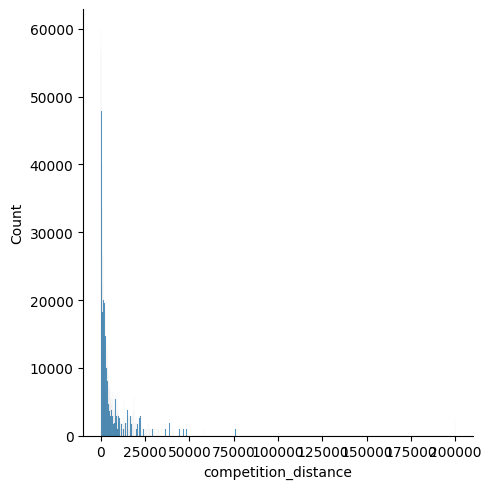

In [16]:
sns.displot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
mont_map          12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

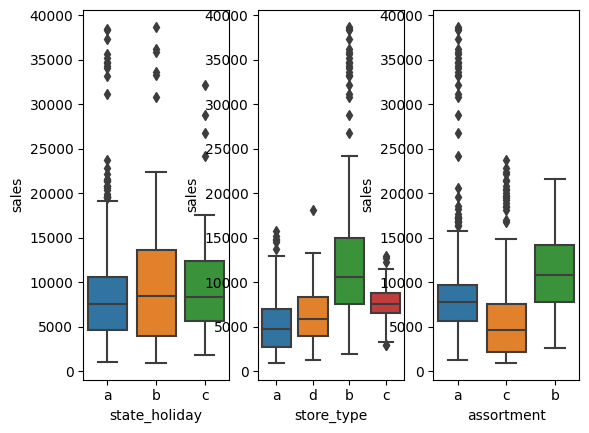

In [18]:
aux = df1[(df1['state_holiday']!='0') & (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y='sales', data = aux)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y='sales', data = aux)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y='sales', data = aux)

# PASSO 02 - FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

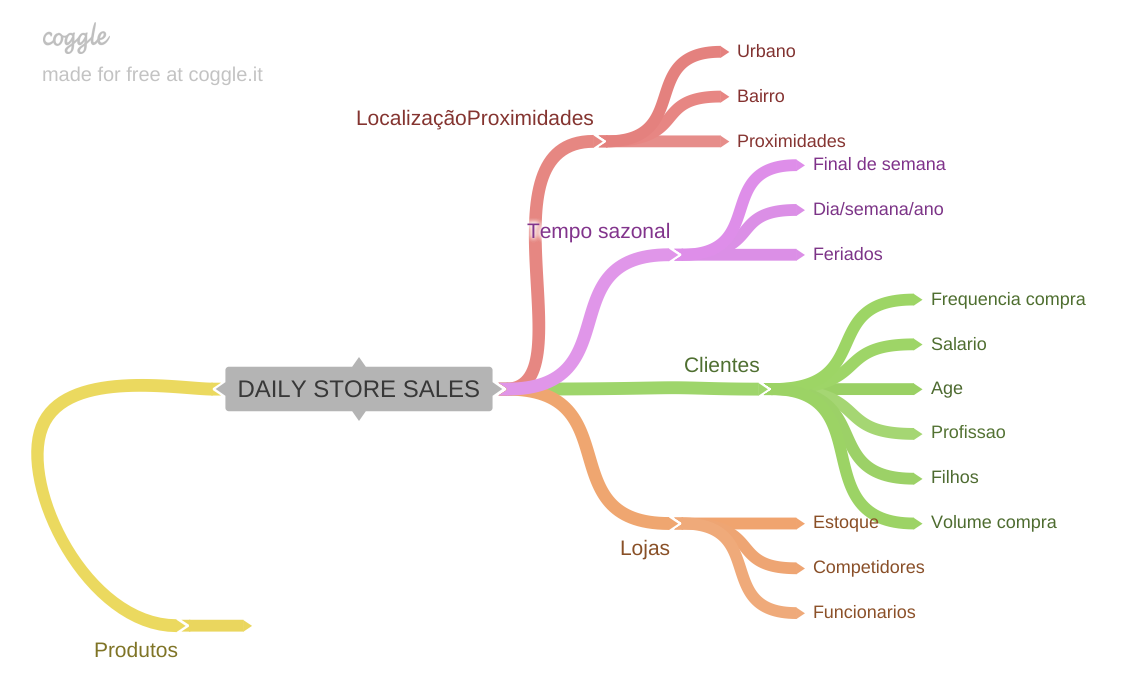

In [20]:
Image('img/mindmap_hip.png')

## 2.1 Criação das Hipóteses 

### 2.1.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com estoque maior deveriam vender mais

**3.** Lojas com maior aporte deveriam vender mais

**4.** Lojas com menor aporte deveriam vender menos

**5.** Lojas com maior sortimento deveriam vender mais

### 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais

**2.** Lojas que expõe mais o produto nas vitrines deveriam vender mais

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais.


### 2.1.3 Hipóteses Tempo

**1.** Lojas que tem mais feriados deveriam vender menos

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais

**3.** Lojas que abrem nos finais de semana deveriam vender mais

## 2.2 Lista Final de Hipóteses (com os dados que temos)

**1.** Lojas com maior sortimentos deveriam vender mais

**2.** Lojas com mais competidores mais próximos deveriam vender menos

**3.** Lojas com competidores à mais tempo deveriam vender mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante o Natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender menos aos finais de semana

**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Feature Engineering

In [21]:
#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


In [22]:
#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] , month = x['competition_open_since_month'], day = 1 ), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) +'-'+ df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x:x.days).astype(int)


In [23]:

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x =='b' else 'christmas' if x=='c' else 'regular_day')

In [24]:
df2['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [26]:
df3 = df2.copy()

### 3.1 Filtragem das Linhas

In [27]:
df3 = df3[(df3['open']!=0) & (df3['sales']>0)]

### 3.2 Seleção das Colunas

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'mont_map']
df3 = df3.drop(cols_drop, axis=1)

In [29]:
df3.head(2).T

,0,1
store,1,2
day_of_week,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064
promo,1,1
state_holiday,regular_day,regular_day
school_holiday,1,1
store_type,c,a
assortment,basic,basic
competition_distance,1270.0,570.0


## PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [30]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4,1 Response Variable

/tmp/ipykernel_11816/1473926699.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales'])


<Axes: xlabel='sales', ylabel='Density'>

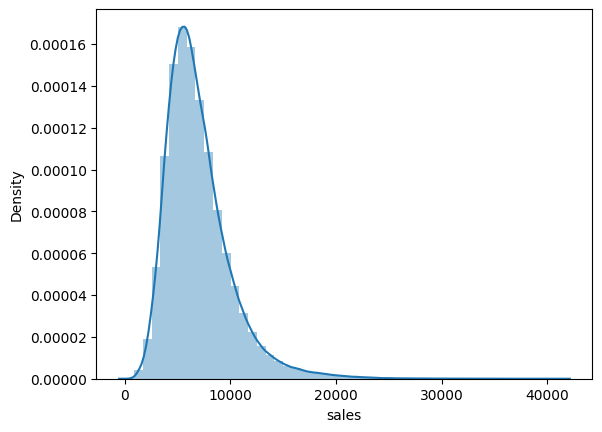

In [31]:
sns.distplot(df4['sales'])

### 4.2 Numerical Variable

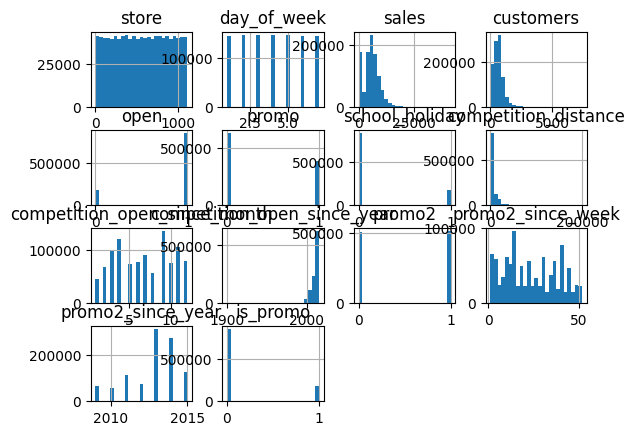

In [32]:
num_attributes.hist(bins=25);

#### 4.3 Categorical Variable

In [33]:
cat_attributes.apply(lambda x: x.unique().shape[0])

df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

In [34]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

/tmp/ipykernel_11816/3731196775.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] =='public_holiday']['sales'], label = 'public_holiday', shade=True)
/tmp/ipykernel_11816/3731196775.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] =='easter_holiday']['sales'], label = 'easter_holiday', shade=True)
/tmp/ipykernel_11816/3731196775.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] =='christmas']['sales'], label = 'christmas', shade=True)
/tmp/ipykernel_11816/3731196775.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setti

<Axes: xlabel='sales', ylabel='Density'>

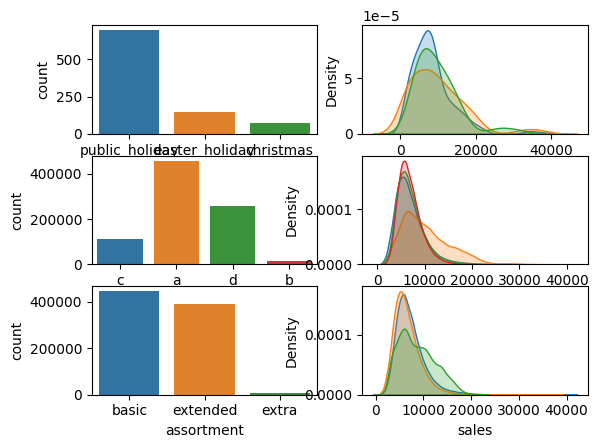

In [35]:
#state holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday']!='regular_day']
sns.countplot(x = a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] =='public_holiday']['sales'], label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] =='easter_holiday']['sales'], label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] =='christmas']['sales'], label = 'christmas', shade=True)

#store_type
plt.subplot(3, 2, 3)
sns.countplot(x = df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] =='a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] =='b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] =='c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] =='d']['sales'], label = 'd', shade=True)


#assertments
plt.subplot(3, 2, 5)
sns.countplot(x = df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] =='extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] =='basic']['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] =='extra']['sales'], label = 'extra', shade=True)

## 4.2 Analise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais



<Axes: xlabel='year_week'>

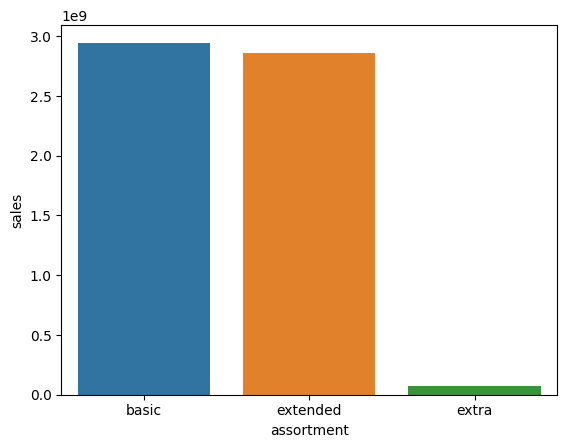

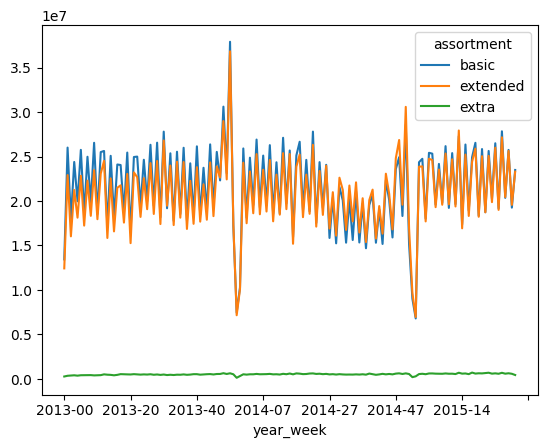

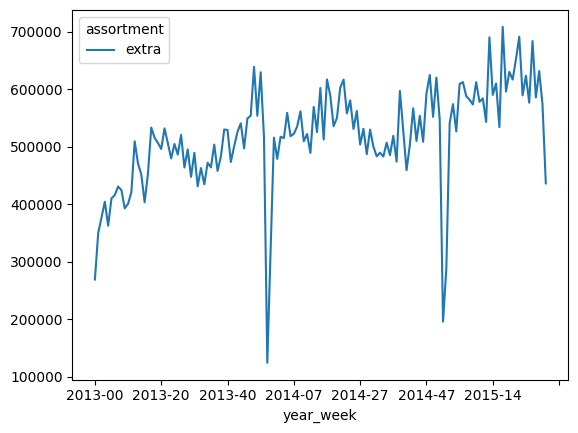

In [39]:
aux = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y='sales', data = aux);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns="assortment", values="sales").plot()

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns = 'assortment', values='sales').plot()

### **H2.** Lojas com mais competidores mais próximos deveriam vender menos



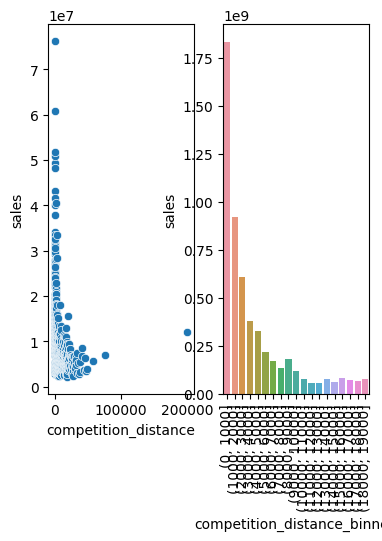

In [71]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1)


plt.subplot(1, 3, 2)
bins  = list(np.arange(0,20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

#plt.subplot(1, 3, 3)
#x = sns.heatmap(aux1.corr(method='pearson'), annot=True);
#bottom, top = x.get_ylim()

In [69]:
aux1.dtypes

competition_distance            float64
sales                             int64
competition_distance_binned    category
dtype: object

### **H3.** Lojas com competidores à mais tempo deveriam vender mais

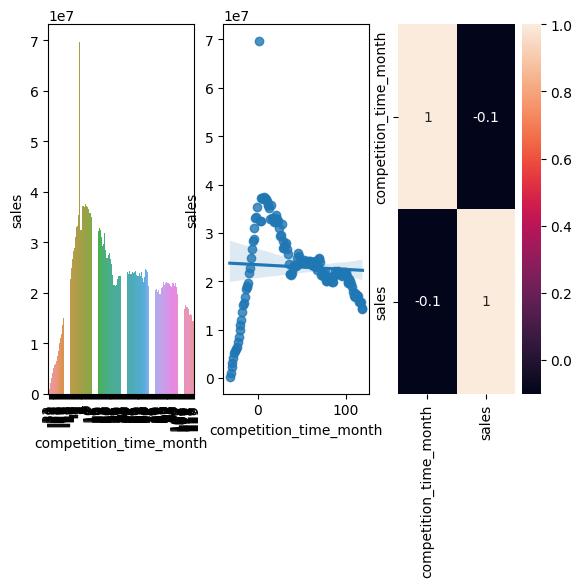

In [63]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month']!=0)]
sns.barplot(x = 'competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);




### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais


<Axes: >

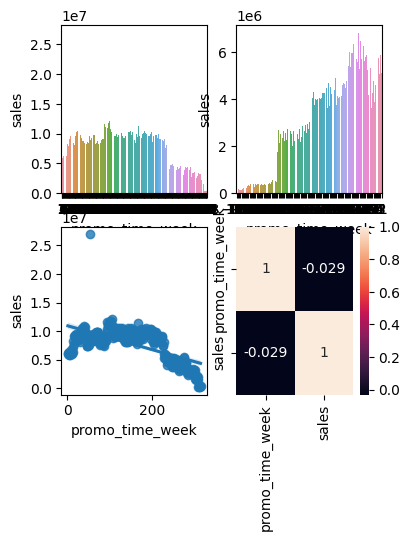

In [83]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot(x='promo_time_week', y = 'sales', data=aux1);

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[0,1])
aux3 = aux1[aux1['promo_time_week']<0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux3);


plt.subplot(grid[1,0])
aux2 = aux1[aux1['promo_time_week']>0] # promo extendido
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,1])
aux3 = aux1[aux1['promo_time_week']<0] # promo extendido
sns.regplot(x='promo_time_week', y='sales', data=aux3);


sns.heatmap(aux1.corr(method='pearson'), annot=True)


### <s> **H5.** Lojas com mais dias de promoção deveriam vender mais </s>



### **H6.** Lojas com mais promoções consecutivas deveriam vender mais



In [84]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


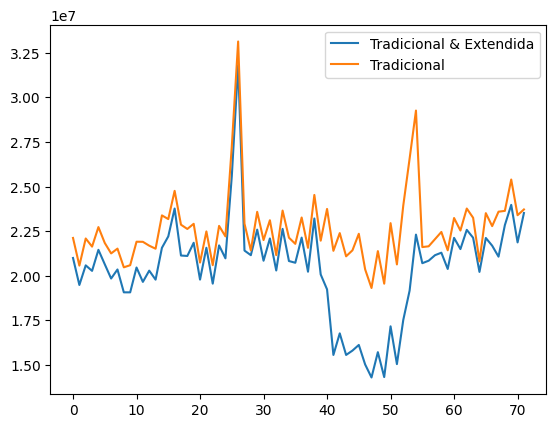

In [89]:
aux1 = df4[(df4['promo']==1 ) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo']==1 ) & (df4['promo2']==0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

ax.legend(labels = ['Tradicional & Extendida', 'Tradicional'])

## 4.3 Analise Multivariada

### **8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSA** 

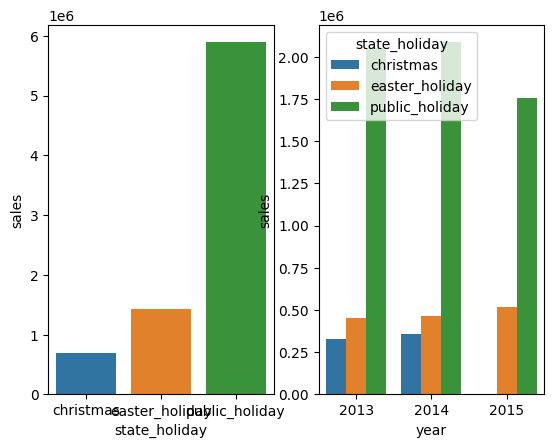

In [97]:
plt.subplot(1,2,1)
aux = df4[df4['state_holiday']!='regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y ='sales', data = aux1)

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);


### **9.** Lojas deveriam vender mais ao longo dos anos
**FALSA**

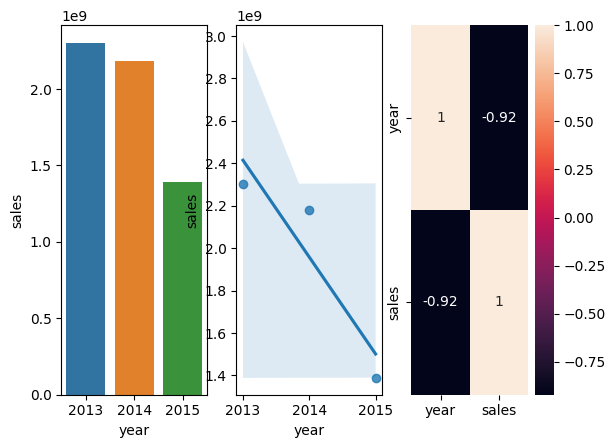

In [106]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data = aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);



### **10.** Lojas deveriam vender mais no segundo semestre do ano
**FALSA**


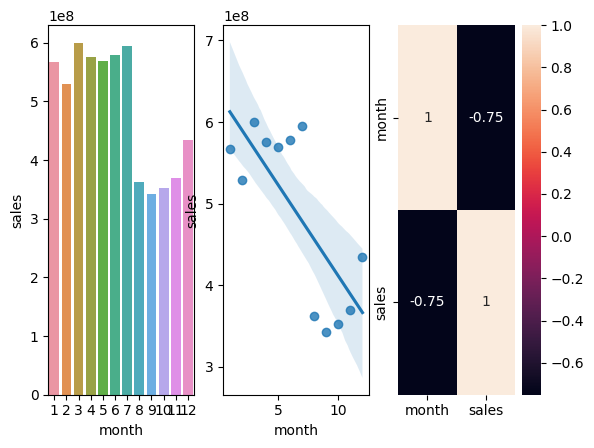

In [108]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data = aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **11.** Lojas deveriam vender mais depois do dia 10 de cada mês



<Axes: xlabel='before_after', ylabel='sales'>

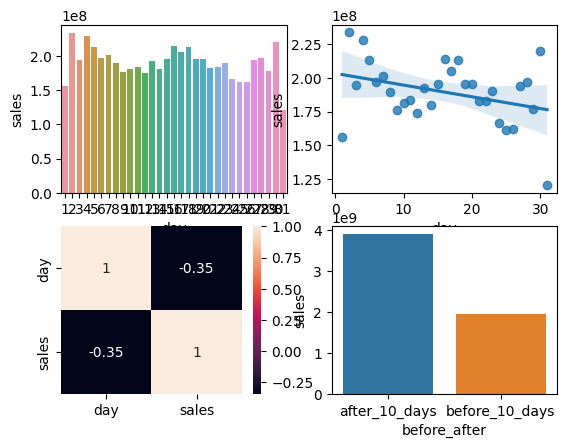

In [111]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data = aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data = aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y='sales', data = aux2 )

### **12.** Lojas deveriam vender menos aos finais de semana

**VERDADEIRA**

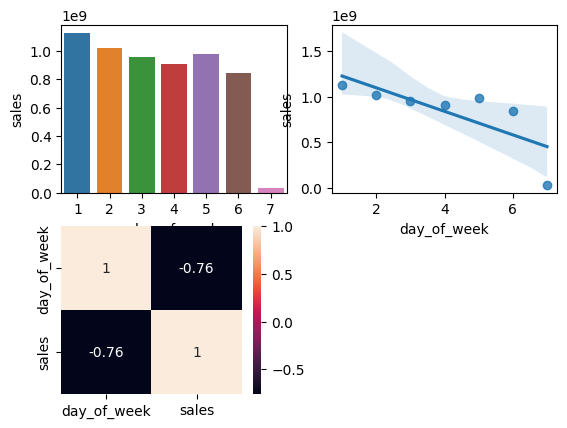

In [112]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day_of_week', y='sales', data = aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day_of_week', y='sales', data = aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### **13.** Lojas deveriam vender menos durante os feriados escolares
**VERDADEIRA**

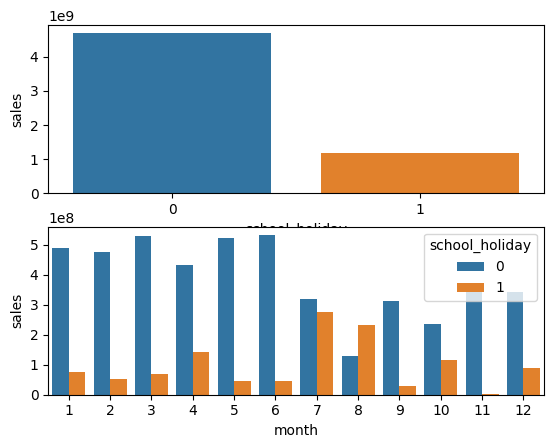

In [115]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data = aux1);

aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data = aux2);
